# Проект по бинарной классификации рисков сердечного приступа

## Обзор и цели

Этот проект посвящён разработке модели бинарной классификации, предсказывающей высокий или низкий риск сердечного приступа по реальным медицинским данным. Цель — провести исследовательский анализ данных (EDA), построить точную и интерпретируемую модель, а затем развернуть её как приложение FastAPI для получения предсказаний на новых данных.

Датасет включает ключевые группы признаков:
- Антропометрия: возраст, индекс массы тела (ИМТ).
- Образ жизни: курение, употребление алкоголя, физическая активность, диета.
- Клинические измерения: артериальное давление, частота сердечных сокращений.
- Лабораторные показатели: холестерин, триглицериды, уровень глюкозы.
- Сердечные биомаркеры: тропонин, CK-MB.
- Медицинский анамнез: диабет, семейная история сердечных заболеваний, прошлые сердечные события, приём лекарств и др.

Проект состоит из двух частей:
1. Анализ данных и построение модели классификации.
2. Развёртывание сервиса на FastAPI для онлайновых предсказаний риска.


## Ключевые задачи

1. **EDA (разведочный анализ):** изучить распределения признаков, выявить аномалии, пропуски и возможные утечки.
2. **Предобработка данных:** обработать пропуски, закодировать категориальные признаки, удалить/трансформировать вводящие в заблуждение признаки.
3. **Инженерия признаков:** использовать доменные знания (например, расчёт риск-скоров, агрегирование факторов риска) для улучшения качества модели.
4. **Моделирование:** обучить и сравнить несколько моделей классификации; акцент на ансамблях (**Random Forest**, **XGBoost**, **CatBoost**), избегая чрезмерно простых подходов.
5. **Метрики и валидация:** выбрать метрики с учётом дисбаланса классов и клинической значимости (например, ROC-AUC, PR-AUC, recall, F2), обосновать выбор.
6. **Интерпретируемость:** применить **SHAP** для выявления ключевых факторов и проверки согласованности поведения модели с медицинскими знаниями.
7. **Продакшн (FastAPI):** разработать сервис, принимающий вход (CSV/JSON) и возвращающий уровни риска в формате JSON.
8. **Документация и код:** подготовить воспроизводимый, структурированный код (ООП-подход), ноутбук с анализом, артефакты предсказаний и инструкцию по использованию.


In [201]:
# Библиотеки
from __future__ import annotations
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal
from numpy.linalg import LinAlgError
import warnings
from IPython.display import Markdown, display

# seaborn для тепловой карты с подписями и шкалой
import seaborn as sns

# VIF для оценки мультиколлинеарности
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Предварительный обзор датасетов

In [202]:
# Функции для предварительного обзора

def quick_overview(df, target=None):
    """Общий обзор: размер, типы, пропуски, дубликаты, баланс таргета."""
    print("Внешний вид:", df.head().T)
    print("Размер:", df.shape)
    print("\nТипы данных:\n", df.dtypes)
    print("\nПропуски (шт):\n", df.isnull().sum())
    dup = df.duplicated().sum()
    print(f"\nДубликатов: {dup} ({dup/len(df)*100:.2f}%)")
    if target and target in df.columns:
        print("\nБаланс таргета:")
        print(df[target].value_counts(normalize=True))


def quick_details(df, target=None, max_unique=10):
    """Детали: статистика чисел, min/max, категориальные частоты, уникальные значения, корреляции."""
    print("\n--- Статистика числовых признаков ---")
    print(df.describe())
    print("\n--- Min/Max по числовым ---")
    desc = df.describe()
    print(desc.loc[['min', 'max']] if 'min' in desc.index else desc[['min', 'max']])
    print("\n--- Частоты категориальных ---")
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].nunique() <= max_unique:
            print(f"\nЧастоты в '{col}':")
            print(df[col].value_counts(dropna=False))
    print("\n--- Уникальные значения категориальных ---")
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f"{col}: {df[col].unique()}")
    if target and target in df.columns:
        print("\n--- Корреляции с таргетом ---")
        print(df.corr(numeric_only=True)[target].sort_values(ascending=False))


def quick_plots(df):
    """Простые графики: гистограммы числовых признаков."""
    df.hist(figsize=(12, 8), bins=30)


=== TRAIN быстрый обзор ===
Внешний вид:                                         0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.359551  0.202247  0.606742  0.730337   
Cholesterol                      0.732143     0.325  0.860714  0.007143   
Heart rate                       0.074244  0.047663  0.055912  0.053162   
Diabetes                              1.0       1.0       1.0       0.0   
Family History                        1.0       1.0       0.0       0.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       0.0       1.0       0.0   
Alcohol Consumption                   1.0       1.0       1.0       1.0   
Exercise Hours Per Week          0.535505   0.06869  0.944001  0.697023   
Diet                                    1         2         2         0   
Previous Heart Problems               1.0       1.0       1

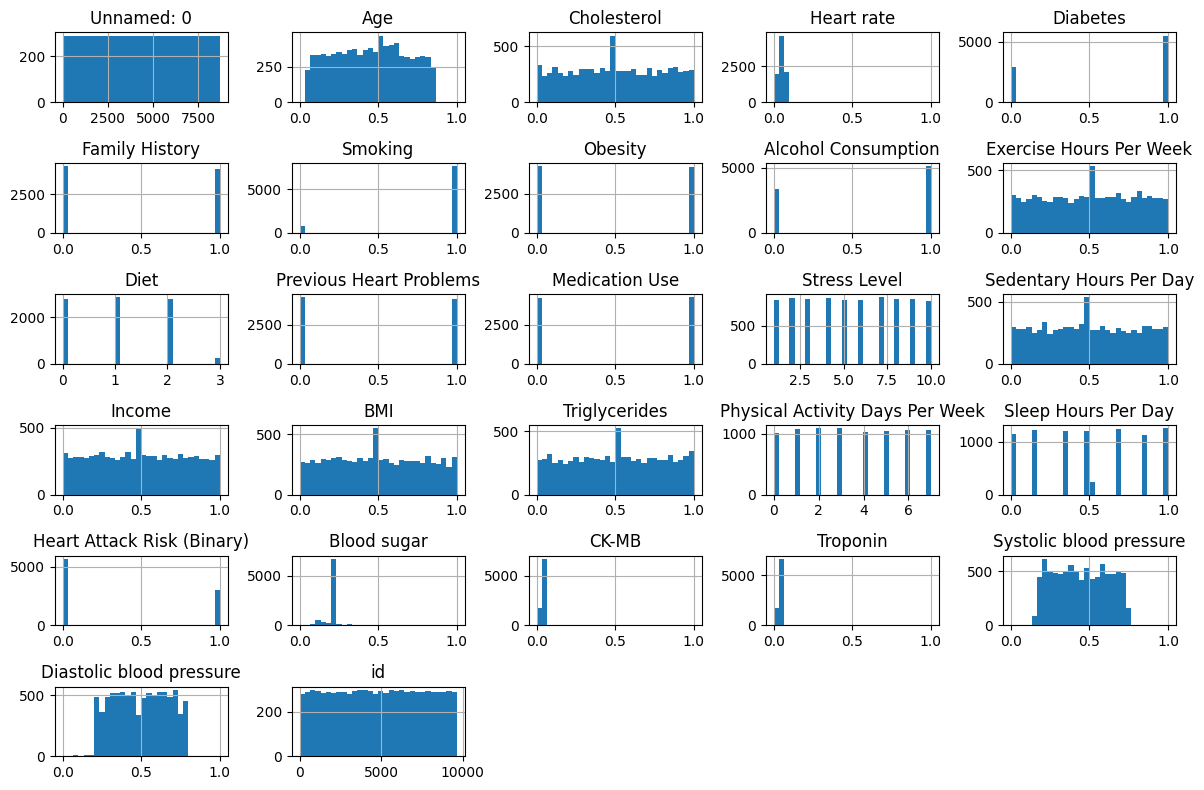


=== TEST быстрый обзор ===
Внешний вид:                                         0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.494382  0.224719  0.629213  0.460674   
Cholesterol                      0.264286  0.953571  0.092857  0.567857   
Heart rate                       0.062328  0.082493  0.064161  0.055912   
Diabetes                              0.0       1.0       0.0       1.0   
Family History                        1.0       0.0       1.0       1.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       1.0       1.0       1.0   
Alcohol Consumption                   1.0       0.0       0.0       1.0   
Exercise Hours Per Week          0.361618  0.996483  0.995561  0.437277   
Diet                                    2         2         0         0   
Previous Heart Problems               0.0       1.0       0

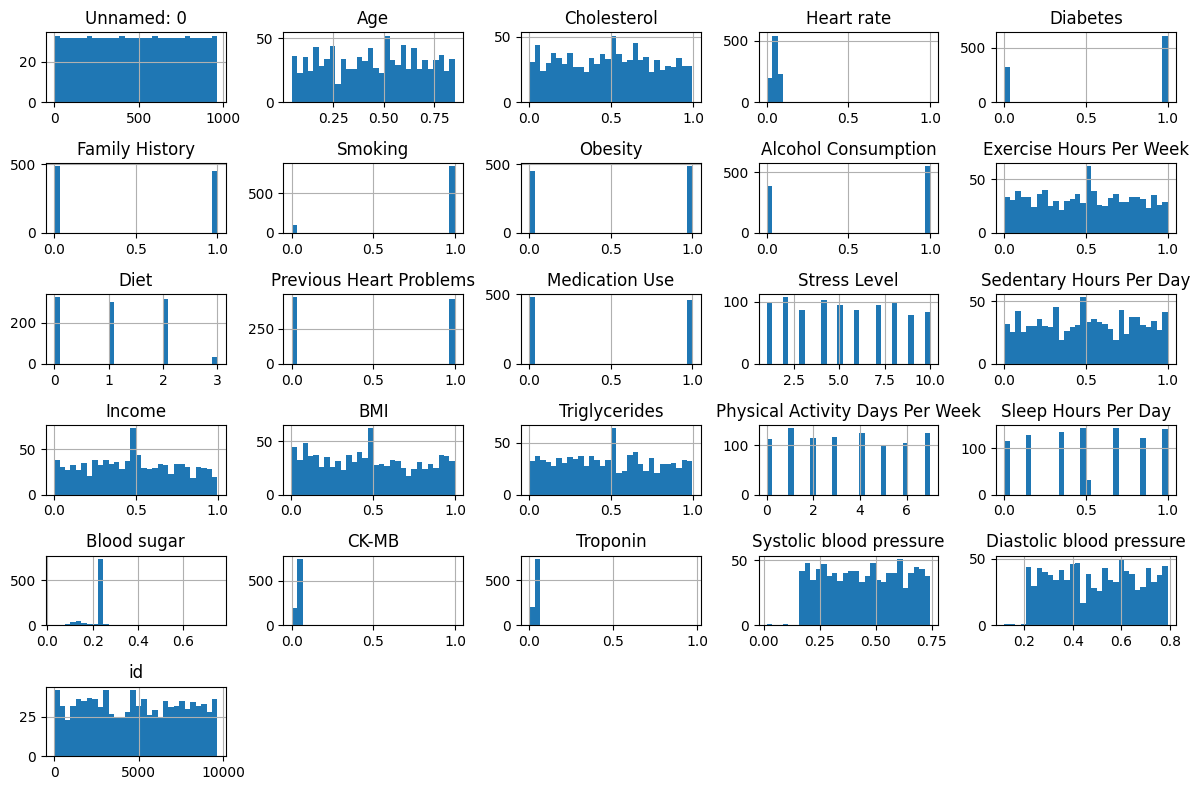

In [203]:
# Рассмотрим датасеты

# === Настройки путей ===
DATA_DIR = Path.cwd().parent / "data"

TRAIN_PATH = DATA_DIR / "heart_train.csv"
TEST_PATH  = DATA_DIR / "heart_test.csv"
TARGET = "Heart Attack Risk (Binary)"  # точное имя таргета из train

# === Загрузка данных ===
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

# === Быстрый обзор train ===
print("=== TRAIN быстрый обзор ===")
quick_overview(train_df, target=TARGET)

print("\n=== TRAIN детали ===")
quick_details(train_df, target=TARGET, max_unique=10)

print("\n=== TRAIN графики ===")
quick_plots(train_df)
plt.tight_layout()
plt.show()

# === Быстрый обзор test (без таргета) ===
print("\n=== TEST быстрый обзор ===")
quick_overview(test_df)  # таргета в test нет

print("\n=== TEST детали ===")
quick_details(test_df, max_unique=10)

print("\n=== TEST графики ===")
quick_plots(test_df)
plt.tight_layout()
plt.show()



# Первичные выводы по датасетам

###  Перечень признаков
- **Unnamed: 0** — служебный индекс из исходного файла (не несёт смысловой нагрузки)
- **Age** — возраст пациента (в нормализованном виде)
- **Cholesterol** — уровень холестерина
- **Heart rate** — частота сердечных сокращений
- **Diabetes** — наличие диабета (`1` — да, `0` — нет)
- **Family History** — наличие семейной истории сердечных заболеваний (`1` — да, `0` — нет)
- **Smoking** — курение (`1` — да, `0` — нет)
- **Obesity** — ожирение (`1` — да, `0` — нет)
- **Alcohol Consumption** — потребление алкоголя (возможно, в нормализованной шкале)
- **Exercise Hours Per Week** — количество часов физической активности в неделю
- **Diet** — качество диеты (в нормализованном виде)
- **Previous Heart Problems** — наличие ранее диагностированных сердечных заболеваний (`1` — да, `0` — нет)
- **Medication Use** — приём лекарственных препаратов (`1` — да, `0` — нет)
- **Stress Level** — уровень стресса
- **Sedentary Hours Per Day** — количество часов сидячего образа жизни в день
- **Income** — доход (в нормализованном виде)
- **BMI** — индекс массы тела
- **Triglycerides** — уровень триглицеридов
- **Physical Activity Days Per Week** — количество дней в неделю с физической активностью
- **Sleep Hours Per Day** — количество часов сна в день
- **Heart Attack Risk (Binary)** — целевая переменная: риск сердечного приступа (`1` — высокий, `0` — низкий)
  *(есть только в train, в test отсутствует)*
- **Blood sugar** — уровень сахара в крови
- **CK-MB** — уровень фермента CK-MB (маркер повреждения сердца)
- **Troponin** — уровень тропонина (маркер повреждения сердца)
- **Gender** — пол пациента (`Male` / `Female`)
- **Systolic blood pressure** — систолическое артериальное давление
- **Diastolic blood pressure** — диастолическое артериальное давление
- **id** — уникальный идентификатор пациента

### Короткий отчёт по первичному обзору датасетов

**1. Общая структура**
- Train: 8685 строк × 28 колонок (включая таргет)
- Test: 966 строк × 27 колонок (без таргета)
- Типы данных: в основном `float64`, немного `int64`, 1 `object` (`Gender`)
- Дубликатов нет

**2. Пропуски**
- Одинаковый набор признаков с ~2.8% пропусков в train и ~3.2% в test:
  `Diabetes`, `Family History`, `Smoking`, `Obesity`, `Alcohol Consumption`,
  `Previous Heart Problems`, `Medication Use`, `Stress Level`,
  `Physical Activity Days Per Week`

**3. Категориальные признаки**
- `Gender` — смешанные форматы (`Male`/`Female` и `0.0`/`1.0`), требуется нормализация
- `Diet` — числовой код (0–3), вероятно категориальная шкала
- Остальные бинарные признаки — 0/1 + пропуски

**4. Нормализация и диапазоны**
- Большинство числовых признаков приведены к диапазону [0, 1] (min–max scaling)
- Дискретные значения в оригинальном диапазоне: `Stress Level` (1–10),
  `Physical Activity Days Per Week` (0–7)
- `Heart rate`, `Blood sugar` имеют выраженные пики на малых значениях
- `CK-MB`, `Troponin` — крайне скошенные распределения, большинство значений ≈0

**5. Баланс таргета (train)**
- 0: 65.3%, 1: 34.7% — умеренный дисбаланс

**6. Корреляции с таргетом**
- Линейные корреляции очень низкие (max ≈ 0.034 для `Systolic blood pressure`)
- Прямая линейная предсказуемость слабая, нужны модели, учитывающие нелинейности и взаимодействия

**7. Наблюдения по гистограммам**
- `Diabetes`, `Smoking`, `Obesity`, `Alcohol Consumption`,
  `Previous Heart Problems`, `Medication Use` — сильный перекос в сторону одного класса
- `Stress Level` и `Physical Activity Days Per Week` — равномерные или почти равномерные распределения по дискретным уровням
- `Sleep Hours Per Day` — несколько фиксированных значений, скорее всего закодированные категории/интервалы сна
- `Gender` — доминирует класс Male
- В тесте распределения очень похожи на train, но у ряда признаков (`Diet`, `Stress Level`) есть перестановка частот отдельных значений
- Много признаков имеют резкие пики (дискретность или предобработка), что надо учесть при фичеинжиниринге

**8. Потенциальные проблемы**
**Утечки**
- **Troponin** — диагностический биомаркер инфаркта миокарда; повышается *после* повреждения сердца. Использование даёт модели фактическое знание о событии.
- **CK-MB** — фермент, растущий при некрозе миокарда; так же измеряется при подозрении/после события. Практически прямой индикатор исхода.
- **Previous Heart Problems** — наличие ранее диагностированных сердечных болезней. По смыслу почти «ярлык класса» и напрямую связан с высокой вероятностью нового события.
- **Medication Use** — приём кардио-лекарств часто назначается после диагноза (ИБС/гипертония/дислипидемия). Это маркер известного заболевания, а не чистый фактор риска.

**Возможные прокси-утечки**
- **Triglycerides** — лабораторный показатель, который могут снимать в остром эпизоде/госпитализации; при неизвестной временной привязке может косвенно сигналить об уже случившемся событии/лечении.
- **Blood sugar** — глюкоза повышается при остром стрессе/инфаркте и часто измеряется в момент обращения; без гарантии замера перед инфарктом становится прокси информации о событии.

**Дополнительная задача**
- Непоследовательная кодировка категорий (`Gender`)



# EDA

1) Загрузка и первичная чистка
   - Удалить технические столбцы (`Unnamed: 0`), они не несут информации и могут «шуметь».
   - Сохранить `id` и проверить его уникальность — нужен для последующего сшивания предсказаний.
   *(Функции: drop_technical_cols, проверка id внутри fit_report)*

2) Приведение типов и кодировок
   - Перекодировать `Gender` в {0,1}; очистить смешанные значения (`'Male'/'Female'` и `0/1`) — иначе модели и корреляции будут работать некорректно.
   *(Функция: encode_gender)*

3) Пропуски: диагностика и импутация
   - В медданных пропуск очень часто может быть содержательно значим: пациент не отвечал/показатель не измеряли. Поэтому **добавляем индикаторы** `*_was_nan`.
   - Импутация: бинарные → мода, порядковые/малоуникальные (`Stress Level`, `Physical Activity Days Per Week`, `Diet`) → округлённая медиана, непрерывные → медиана. Это даёт устойчивую точку отсчёта без утечки таргета.
   *(Функции: report_missing, flag_and_impute_missing)*

4) Поиск подозрительных «пиков» распределений
   - Зафиксировать признаки с резкими пиками в окрестности 0/0.5/1 (следствие предобработки/категоризации). Пометить их для последующего фичеинжиниринга.
   *(Функция: detect_suspicious_peaks)*

5) Маркировка утечек и прокси-утечек
   - Явные утечки: `Troponin`, `CK-MB`, `Previous Heart Problems`, `Medication Use` — **исключать из обучения** (но сохранять для анализа).
   - Прокси-утечки: `Triglycerides`, `Blood sugar` — **не удаляем на EDA**, будем сравнивать метрики «с ними/без них» на этапе моделирования.
   *(Функция: separate_feature_sets)*

6) Корреляции и мультиколлинеарность
   - Построить матрицу корреляций **Spearman** (лучше для порядковых/не-нормальных), с цветовой шкалой сбоку и числовыми подписями в ячейках — быстро видно группы высокозависимых признаков.
   - Оценить VIF и выписать признаки с VIF≫10 как кандидатов на исключение/регуляризацию.
   *(Функции: corr_heatmap, vif_report)*

7) Согласованность train/test
   - Сравнить распределения (числовые и категориальные) между train и test, чтобы заметить возможный дрифт/рассинхрон частот. Если отличаются — пометить для робастного препроцесса.
   *(Функция: train_test_alignment — при необходимости)*

8) Вывод и фиксация решений
   - Сформировать краткий Markdown-итог: что удалено, как кодирован `Gender`, как обрабатывались пропуски, какие «пики» найдены, какие пары скоррелированы, какие признаки — утечки/прокси, кто имеет высокий VIF.
   *(Функция: summarize_eda_findings / summary_md из fit_report)*

> Результат: подготовленные `train_clean/test_clean`, сохранённые `ids`, списки `safe_cols/proxy_cols/leakage_cols`, отчёты по пропускам/пикам/корреляциям/VIF. Это даёт чистую базу для фичеинжиниринга и честного сравнения моделей (с прокси и без).


In [204]:
# Класс EDA
class EDAHelper:
    """
    Помощник для EDA под проект М1.
    Делает:
      - удаление технич. колонок, сохранение id
      - перекодировку Gender -> {0,1}
      - отчёт/импутацию пропусков + индикаторы _was_nan
      - поиск пиков (автоматически по гистограмме)
      - разбиение фичей на safe / proxy / leakage
      - heatmap корреляций
      - отчёт по VIF
      - распределение таргета по классам
      - распределение таргета по признакам (таблицы + графики)
      - проверку утечки ID между train/test
      - fit_report(train, test): оркестратор + markdown-вывод
    """

    def __init__(
        self,
        target: str = "Heart Attack Risk (Binary)",
        id_col: str = "id",
        technical_cols: tuple = ("Unnamed: 0",),
        leakage_cols: tuple = ("Troponin", "CK-MB", "Previous Heart Problems", "Medication Use"),
        proxy_cols: tuple = ("Triglycerides", "Blood sugar"),
        ordinal_cols_guess: tuple = ("Stress Level", "Physical Activity Days Per Week", "Diet"),
        gender_col: str = "Gender",
        gender_map: dict = None,
    ):
        # Храним ключевые имена колонок/наборы
        self.target = target
        self.id_col = id_col
        self.technical_cols = technical_cols
        self.leakage_cols = tuple(leakage_cols)
        self.proxy_cols = tuple(proxy_cols)
        self.ordinal_cols_guess = tuple(ordinal_cols_guess)
        self.gender_col = gender_col
        self.gender_map = gender_map or {"male": 1, "female": 0, "m": 1, "f": 0}

        # Полезное состояние после fit_report
        self.ids_train = None
        self.ids_test = None
        self.missing_report_train = None
        self.missing_report_test = None
        self.vif_table = None
        self.peaks_table = None
        self.outliers_table = None
        self.corr_matrix = None
        self.summary_md = None
        self.target_dist = None            # распределение таргета по классам (train)
        self.id_check = None               # проверка уникальности и пересечения id
        self.target_by_cats = None         # таблица: таргет по категориальным/порядковым/флагам was_nan
        self.target_by_quants = None       # таблица: таргет по квантилям непрерывных

    # ---------- ВСПОМОГАТЕЛЬНЫЕ МЕТОДЫ ТИПОВ ----------

    def _numeric_cols(self, df: pd.DataFrame) -> list:
        """Возвращает список числовых признаков, исключая id и таргет."""
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
        return [c for c in cols if c not in (self.id_col, self.target)]

    def _binary_cols(self, df: pd.DataFrame) -> list:
        """Ищет бинарные признаки: уникальные значения подмножеством {0,1} (без NaN)."""
        out = []
        for c in self._numeric_cols(df):
            vals = set(pd.Series(df[c].dropna().unique()).tolist())
            if vals and vals.issubset({0, 1, 0.0, 1.0}):
                out.append(c)
        return out

    def _ordinal_cols(self, df: pd.DataFrame) -> list:
        """Ищет очевидные порядковые признаки по именам (простая эвристика)."""
        present = [c for c in self.ordinal_cols_guess if c in df.columns]
        return present

    def _small_cardinality_numeric(self, df: pd.DataFrame, max_unique: int = 10) -> list:
        """Числовые признаки с малым числом уникальных значений (могут быть категориальные/порядковые)."""
        out = []
        for c in self._numeric_cols(df):
            nuniq = df[c].nunique(dropna=True)
            if nuniq <= max_unique:
                out.append(c)
        return out

    # ---------- ПОДГОТОВКА ДАННЫХ ----------

    def drop_technical_cols(self, df: pd.DataFrame) -> pd.DataFrame:
        """Удаляет служебные столбцы (например, 'Unnamed: 0'), но НЕ трогает id."""
        tech = [c for c in df.columns if c in self.technical_cols or re.match(r"^Unnamed", c or "", flags=re.I)]
        return df.drop(columns=tech, errors="ignore")

    def encode_gender(self, df: pd.DataFrame) -> pd.DataFrame:
        """Перекодирует Gender в {0,1}; чистит смешанные значения ('0.0','1.0', строки)."""
        if self.gender_col not in df.columns:
            return df
        ser = df[self.gender_col]
        as_str = ser.astype(str).str.strip().str.lower()
        mapped = as_str.map(self.gender_map)
        unmapped_mask = mapped.isna()
        if unmapped_mask.any():
            as_num = pd.to_numeric(as_str, errors="coerce")
            as_num = as_num.where(as_num.isin([0, 1]), np.nan)
            mapped = mapped.where(~unmapped_mask, as_num)
        df[self.gender_col] = mapped.astype("float").astype("Int64").astype("float").fillna(np.nan)
        return df

    def report_missing(self, df: pd.DataFrame) -> pd.Series:
        """Возвращает серию с количеством пропусков по колонкам (сортировка по убыванию)."""
        return df.isnull().sum().sort_values(ascending=False)

    def flag_and_impute_missing(
        self,
        df: pd.DataFrame,
        binary_cols: list | None = None,
        ordinal_cols: list | None = None,
    ) -> pd.DataFrame:
        """
        Создаёт индикаторы пропусков *_was_nan и заполняет пропуски:
          - бинарные -> мода
          - порядковые -> медиана (округлённая)
          - другие числовые -> медиана
        Объектные/строковые колонки не трогаем.
        """
        df = df.copy()
        numeric_cols = self._numeric_cols(df)
        binary_cols = binary_cols or self._binary_cols(df)
        ordinal_cols = ordinal_cols or self._ordinal_cols(df)

        for c in numeric_cols:
            if df[c].isna().any():
                df[f"{c}_was_nan"] = df[c].isna().astype(int)
                if c in binary_cols:
                    mode_val = df[c].mode(dropna=True)
                    fill_val = float(mode_val.iloc[0]) if not mode_val.empty else 0.0
                    df[c] = df[c].fillna(fill_val).clip(0, 1)
                elif c in ordinal_cols or c in self._small_cardinality_numeric(df):
                    med = df[c].median(skipna=True)
                    df[c] = df[c].fillna(round(med))
                else:
                    med = df[c].median(skipna=True)
                    df[c] = df[c].fillna(med)
        return df

    # ---------- ПИКИ / ВЫБРОСЫ ----------

    def detect_peaks_auto(
        self,
        df: pd.DataFrame,
        bins: str | int = "fd",
        min_share: float = 0.03,
        prominence: float = 2.0,
        top_k: int = 3,
        skip_missing_indicators: bool = True,
        skip_binary: bool = True,
        min_unique: int = 11,
        as_percent: bool = True,
        decimals: int = 2
    ) -> pd.DataFrame:
        """
        Автопоиск локальных пиков по гистограмме без заранее заданных значений.
        Пик = столбик гистограммы, превышающий соседей и медиану ненулевых частот * 'prominence'.
        Возвращает центры бинов и доли/проценты наблюдений в них.
        """
        cols = self._numeric_cols(df)
        if skip_missing_indicators:
            cols = [c for c in cols if not c.endswith("_was_nan")]
        if skip_binary:
            tmp = []
            for c in cols:
                vals = df[c].dropna().unique()
                if len(vals) <= 2 and set(vals).issubset({0, 1}):
                    continue
                if df[c].nunique(dropna=True) < min_unique:
                    continue
                tmp.append(c)
            cols = tmp

        rows = []
        for c in cols:
            s = df[c].dropna().values
            if s.size < 5:
                continue
            counts, edges = np.histogram(s, bins=bins)
            if counts.sum() == 0:
                continue
            nz = counts[counts > 0]
            med = np.median(nz) if nz.size else 0
            n = int(s.size)
            for i in range(1, len(counts) - 1):
                left, mid, right = counts[i-1], counts[i], counts[i+1]
                if mid > left and mid > right and mid >= med * prominence:
                    share = mid / n
                    if share >= min_share:
                        center = (edges[i] + edges[i+1]) / 2
                        rows.append({
                            "feature": c,
                            "bin_center": float(center),
                            "bin_left": float(edges[i]),
                            "bin_right": float(edges[i+1]),
                            "count": int(mid),
                            "pct_in_bin": round(share * 100, decimals) if as_percent else share,
                        })
        peaks = pd.DataFrame(rows)
        if peaks.empty:
            return peaks
        key = "pct_in_bin" if as_percent else "count"
        peaks = peaks.sort_values(["feature", key], ascending=[True, False])
        peaks = peaks.groupby("feature").head(top_k).reset_index(drop=True)
        return peaks

    def detect_outliers(
        self,
        df: pd.DataFrame,
        method: str = "iqr",
        iqr_factor: float = 1.5,
        mad_z: float = 3.5,
        skip_missing_indicators: bool = True,
        skip_binary: bool = True,
        min_unique: int = 11,
        as_percent: bool = True,
        decimals: int = 2
    ) -> pd.DataFrame:
        """
        Короткий отчёт по выбросам.
        - IQR: границы [Q1 - k*IQR, Q3 + k*IQR]
        - MAD: |x - median| / (1.4826*MAD) > mad_z
        """
        cols = self._numeric_cols(df)
        if skip_missing_indicators:
            cols = [c for c in cols if not c.endswith("_was_nan")]
        if skip_binary:
            tmp = []
            for c in cols:
                vals = df[c].dropna().unique()
                if len(vals) <= 2 and set(vals).issubset({0, 1}):
                    continue
                if df[c].nunique(dropna=True) < min_unique:
                    continue
                tmp.append(c)
            cols = tmp

        rows = []
        for c in cols:
            s = df[c].dropna().values
            n = s.size
            if n < 5:
                continue
            if method.lower() == "mad":
                med = np.median(s)
                mad = np.median(np.abs(s - med))
                denom = (1.4826 * mad) if mad > 0 else np.inf
                z = np.abs(s - med) / denom
                mask = z > mad_z
                lower, upper = None, None
            else:
                q1, q3 = np.percentile(s, [25, 75])
                iqr = q3 - q1
                lower = q1 - iqr_factor * iqr
                upper = q3 + iqr_factor * iqr
                mask = (s < lower) | (s > upper)
            share = mask.mean()
            if share == 0:
                continue
            rows.append({
                "Признак": c,
                "N": int(n),
                "% выбросов": round(share * 100, decimals) if as_percent else share,
                "Нижняя граница": None if lower is None else float(lower),
                "Верхняя граница": None if upper is None else float(upper),
                "Мин. выброс": float(np.min(s[mask])) if mask.any() else None,
                "Макс. выброс": float(np.max(s[mask])) if mask.any() else None,
            })
        return pd.DataFrame(rows).sort_values("% выбросов" if as_percent else "N", ascending=False)

    # ---------- РАСПРЕДЕЛЕНИЕ ТАРГЕТА (общая, по признакам) / ПРОВЕРКА ID ----------

    def target_distribution(self, df: pd.DataFrame) -> pd.DataFrame:
        """Возвращает распределение таргета по классам (train): 'Класс', 'Количество', '%'."""
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден в DataFrame.")
        vc = df[self.target].value_counts().sort_index()
        n = int(vc.sum())
        out = pd.DataFrame({
            "Класс": vc.index.astype(int),
            "Количество": vc.values,
            "%": (vc.values / n * 100).round(2)
        }).reset_index(drop=True)
        return out

    def target_rate_by(
        self,
        df: pd.DataFrame,
        cols: list | None = None,
        include_proxy: bool = False,
        include_missing_indicators: bool = True,
        max_levels: int = 20
    ) -> pd.DataFrame:
        """
        Таблица долей класса=1 по группам для категориальных/порядковых/бинарных признаков.
        - По умолчанию исключает явные утечки; прокси можно включить флагом.
        - Флаги *_was_nan по умолчанию ВКЛЮЧЕНЫ (важно для понимания роли пропусков).
        """
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден.")
        # авто-выбор, если cols не задан
        use_cols = []
        if cols is None:
            base = self._binary_cols(df) + self._ordinal_cols(df) + ([self.gender_col] if self.gender_col in df.columns else [])
            if include_missing_indicators:
                base += [c for c in df.columns if isinstance(c, str) and c.endswith("_was_nan")]
            use_cols = list(dict.fromkeys([c for c in base if c in df.columns]))
        else:
            use_cols = [c for c in cols if c in df.columns]
            if include_missing_indicators:
                use_cols += [c for c in df.columns if isinstance(c, str) and c.endswith("_was_nan")]
                use_cols = list(dict.fromkeys(use_cols))

        # исключаем утечки; прокси по флагу
        use_cols = [c for c in use_cols if c not in self.leakage_cols]
        if not include_proxy:
            use_cols = [c for c in use_cols if c not in self.proxy_cols]
        if not use_cols:
            return pd.DataFrame(columns=["Признак", "Значение", "N", "% класса=1"])

        rows = []
        for c in use_cols:
            vc = df[c].value_counts(dropna=False)
            kept = set(vc.head(max_levels).index.tolist())
            dfx = df.copy()
            dfx[c] = dfx[c].where(dfx[c].isin(kept), other="__Другое__")
            grp = dfx.groupby(c, dropna=False)[self.target].agg(rate="mean", n="count").reset_index()
            for _, r in grp.iterrows():
                rows.append({
                    "Признак": c,
                    "Значение": r[c],
                    "N": int(r["n"]),
                    "% класса=1": round(float(r["rate"]) * 100, 2)
                })
        out = pd.DataFrame(rows).sort_values(["Признак", "% класса=1"], ascending=[True, False]).reset_index(drop=True)
        return out

    def risk_by_quantiles(
        self,
        df: pd.DataFrame,
        cols: list | None = None,
        q: int = 10,
        include_proxy: bool = False
    ) -> pd.DataFrame:
        """
        Таблица долей класса=1 по квантилям непрерывных признаков.
        - Исключает явные утечки и *_was_nan; прокси можно включить флагом.
        """
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден.")
        # авто-выбор, если cols не задан
        if cols is None:
            num = [c for c in self._numeric_cols(df) if not c.endswith("_was_nan") and c not in self.leakage_cols]
            if not include_proxy:
                num = [c for c in num if c not in self.proxy_cols]
            # оставим «небинарные» и достаточно разнообразные
            def is_cont(col):
                s = df[col]
                return s.dropna().nunique() >= max(11, q) and not set(s.dropna().unique()).issubset({0, 1})
            cols = [c for c in num if is_cont(c)]

        rows = []
        for c in cols:
            s = df[c]
            if s.dropna().nunique() < max(5, q):
                continue
            try:
                bins = pd.qcut(s, q=q, duplicates="drop")
            except Exception:
                continue
            grp = df.groupby(bins, dropna=True, observed=False)[self.target].agg(rate="mean", n="count").reset_index()
            for _, r in grp.iterrows():
                iv = r[c]
                rows.append({
                    "Признак": c,
                    "Квантиль": str(iv),
                    "Мин": float(iv.left),
                    "Макс": float(iv.right),
                    "N": int(r["n"]),
                    "% класса=1": round(float(r["rate"]) * 100, 2)
                })
        out = pd.DataFrame(rows).sort_values(["Признак", "Квантиль"]).reset_index(drop=True)
        return out

    def check_id_integrity(self, train: pd.DataFrame, test: pd.DataFrame) -> dict:
        """
        Проверка ID:
          - уникальность id в train и test
          - пересечение id между выборками (утечка)
        Возвращает словарь с подсчётами и примером пересечений (до 10 шт).
        """
        if self.id_col not in train.columns or self.id_col not in test.columns:
            return {"ok": False, "msg": f"Колонка id '{self.id_col}' не найдена в одной из выборок."}
        tr_ids = train[self.id_col]; ts_ids = test[self.id_col]
        dup_train = int(tr_ids.duplicated().sum()); dup_test = int(ts_ids.duplicated().sum())
        inter = set(tr_ids.tolist()).intersection(set(ts_ids.tolist()))
        return {
            "ok": (dup_train == 0 and dup_test == 0 and len(inter) == 0),
            "train_ids": int(tr_ids.nunique()),
            "test_ids": int(ts_ids.nunique()),
            "dup_train": dup_train,
            "dup_test": dup_test,
            "intersection": len(inter),
            "intersection_sample": list(sorted(inter))[:10],
        }

    # ---------- КОРРЕЛЯЦИИ / VIF ----------

    def corr_heatmap(
        self,
        df: pd.DataFrame,
        method: str = "spearman",
        figsize: tuple = (12, 10),
        annot: bool = True,
        fmt: str = ".2f",
        cbar: bool = True,
        vmax: float | None = None,
        include_missing_indicators: bool = False,
        annot_size: int = 7,
        show: bool = True,
    ) -> pd.DataFrame:
        """
        Теплокарта корреляций. По умолчанию ИСКЛЮЧАЕТ *_was_nan,
        чтобы не засорять матрицу корреляций.
        """
        num_cols = self._numeric_cols(df) + ([self.target] if self.target in df.columns else [])
        if not include_missing_indicators:
            num_cols = [c for c in num_cols if not c.endswith("_was_nan")]
        mat = df[num_cols].corr(method=method)
        if show:
                plt.figure(figsize=figsize)
                sns.heatmap(
                    mat, annot=annot, fmt=fmt, cmap="coolwarm",
                    vmin=-1, vmax=1 if vmax is None else vmax, cbar=cbar,
                    annot_kws={"size": annot_size}
                )
                plt.title(f"Корреляции ({method})")
                plt.tight_layout()
                plt.show()
        return mat

    def vif_report(self, df: pd.DataFrame, drop_cols: list | None = None) -> pd.DataFrame:
        """
        VIF без таргета / id и БЕЗ *_was_nan.
        """
        X = df.copy()
        for col in [self.id_col, self.target]:
            if col in X.columns:
                X = X.drop(columns=col)
        if drop_cols:
            X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")
        X = X[[c for c in X.columns if not c.endswith("_was_nan")]]
        X = X.select_dtypes(include=[np.number]).copy()
        zero_var = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
        X = X.drop(columns=zero_var, errors="ignore")
        if X.shape[1] < 2:
            return pd.DataFrame(columns=["feature", "VIF"])
        vif_rows = []
        for i, col in enumerate(X.columns):
            try:
                vif = variance_inflation_factor(X.values, i)
            except Exception:
                vif = np.nan
            vif_rows.append({"feature": col, "VIF": float(vif)})
        return pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)

    # ---------- ПРОСТЫЕ ВИЗУАЛИЗАЦИИ ТАРГЕТА ПО ПРИЗНАКАМ ----------

    def plot_target_rate_by_cats(
        self,
        df: pd.DataFrame,
        cols: list | None = None,
        include_proxy: bool = False,
        include_missing_indicators: bool = True,
        max_levels: int = 8,
        ncols: int = 3,
        height: float = 3.0
    ):
        """
        Рисует компактную панель bar-чартов: доля класса=1 по группам для категориальных/порядковых/флагов *_was_nan.
        По умолчанию исключает явные утечки, прокси — по флагу.
        """
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден.")
        # авто-выбор
        use = cols if cols is not None else list(set(
            self._binary_cols(df) + self._ordinal_cols(df) + ([self.gender_col] if self.gender_col in df.columns else [])
        ))
        if include_missing_indicators:
            use += [c for c in df.columns if isinstance(c, str) and c.endswith("_was_nan")]
        use = [c for c in use if c in df.columns and c not in self.leakage_cols]
        if not include_proxy:
            use = [c for c in use if c not in self.proxy_cols]
        if not use:
            print("Нет подходящих категориальных/порядковых признаков для графиков.")
            return

        n = len(use); ncols = max(1, ncols); nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, height*nrows), squeeze=False)
        ax_iter = (ax for row in axes for ax in row)

        for c, ax in zip(use, ax_iter):
            vc = df[c].value_counts(dropna=False)
            keep = set(vc.head(max_levels).index.tolist())
            dfx = df.copy()
            dfx[c] = dfx[c].where(dfx[c].isin(keep), other="__Другое__")
            grp = dfx.groupby(c, dropna=False, observed=False)[self.target].agg(rate="mean", n="count").reset_index()
            grp = grp.sort_values("rate", ascending=False)
            ax.bar(grp[c].astype(str), grp["rate"]*100)
            ax.set_title(f"{c} (N={int(df[c].notna().sum())})", fontsize=10)
            ax.set_ylabel("% класса=1"); ax.set_xlabel("")
            ax.tick_params(axis="x", labelrotation=30)

        for ax in ax_iter:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    def plot_box_by_target(
        self,
        df: pd.DataFrame,
        cols: list | None = None,
        include_proxy: bool = False,
        ncols: int = 3,
        height: float = 3.0,
        max_plots: int = 9
    ):
        """
        Рисует компактную панель boxplot'ов: непрерывные фичи vs таргет (0/1).
        Исключает явные утечки и *_was_nan; прокси — по флагу.
        """
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден.")
        num = [c for c in self._numeric_cols(df) if not c.endswith("_was_nan") and c not in self.leakage_cols]
        if not include_proxy:
            num = [c for c in num if c not in self.proxy_cols]

        def is_cont(col):
            s = df[col]
            return s.dropna().nunique() >= 11 and not set(s.dropna().unique()).issubset({0, 1})

        use = [c for c in (cols if cols else num) if c in df.columns and is_cont(c)]
        if not use:
            print("Нет подходящих непрерывных признаков для boxplot.")
            return
        use = use[:max_plots]

        n = len(use); ncols = max(1, ncols); nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, height*nrows), squeeze=False)
        ax_iter = (ax for row in axes for ax in row)

        df_ = df.copy()
        df_[self.target] = df_[self.target].astype(int).astype(str)

        for c, ax in zip(use, ax_iter):
            sns.boxplot(data=df_, x=self.target, y=c, ax=ax)
            ax.set_title(c, fontsize=10)
            ax.set_xlabel("Класс таргета"); ax.set_ylabel(c)

        for ax in ax_iter:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    # ---------- ФИЧЕ-СЕТЫ ----------

    def separate_feature_sets(self, df: pd.DataFrame) -> dict:
        """
        Разделяет фичи на:
          - safe_cols: все числовые признаки БЕЗ leakage (proxy пока остаются)
          - proxy_cols: пересечение датасета с заданным списком прокси
          - leakage_cols: пересечение датасета с заданным списком утечек
        Возвращает словарь с тремя списками имён колонок.
        """
        all_num = self._numeric_cols(df)
        leakage_present = [c for c in self.leakage_cols if c in df.columns]
        proxy_present = [c for c in self.proxy_cols if c in df.columns]
        safe_cols = [c for c in all_num if c not in leakage_present]
        return {"safe_cols": safe_cols, "proxy_cols": proxy_present, "leakage_cols": leakage_present}

    # ---------- ГЛАВНЫЙ ПАЙПЛАЙН ----------

    def fit_report(self, train: pd.DataFrame, test: pd.DataFrame) -> dict:
        """
        Полный цикл EDA-подготовки (ничего лишнего не рисует автоматически).
        """
        # 1) Технич. столбцы
        tr = self.drop_technical_cols(train); ts = self.drop_technical_cols(test)
        # 2) Gender
        tr = self.encode_gender(tr); ts = self.encode_gender(ts)
        # 3) ID
        if self.id_col in tr.columns: self.ids_train = tr[self.id_col].copy()
        if self.id_col in ts.columns: self.ids_test  = ts[self.id_col].copy()
        self.id_check = self.check_id_integrity(tr, ts)
        # 4) Пропуски + импутация
        self.missing_report_train = self.report_missing(tr); self.missing_report_test = self.report_missing(ts)
        tr = self.flag_and_impute_missing(tr); ts = self.flag_and_impute_missing(ts)
        # 5) Пики/выбросы
        self.peaks_table = self.detect_peaks_auto(tr, bins="fd", min_share=0.03, prominence=2.0, top_k=3)
        self.outliers_table = self.detect_outliers(tr, method="iqr", iqr_factor=1.5)
        # 6) Корреляции
        self.corr_matrix = self.corr_heatmap(tr, method="spearman", annot=True, cbar=True, show=False)
        # 7) VIF (на safe)
        feat_sets = self.separate_feature_sets(tr)
        vif_base = tr[[c for c in feat_sets["safe_cols"] if c != self.target]].copy()
        self.vif_table = self.vif_report(vif_base)
        # 7b) Распределения таргета (числа)
        self.target_dist = self.target_distribution(tr)
        self.target_by_cats = self.target_rate_by(tr, include_proxy=False, include_missing_indicators=True)
        self.target_by_quants = self.risk_by_quantiles(tr, cols=None, q=10, include_proxy=False)
        # 8) Фиче-наборы
        feature_sets = self.separate_feature_sets(tr)
        # 9) Саммари
        self.summary_md = self._build_summary_md(train, test, feature_sets)

        out = {
            "train_clean": tr.copy(),
            "test_clean": ts.copy(),
            "ids_train": self.ids_train,
            "ids_test": self.ids_test,
            "feature_sets": feature_sets,
            "reports": {
                "missing_train": self.missing_report_train,
                "missing_test": self.missing_report_test,
                "peaks": self.peaks_table,
                "outliers": self.outliers_table,
                "corr_matrix": self.corr_matrix,
                "vif": self.vif_table,
                "target_distribution": self.target_dist,
                "target_by_cats": self.target_by_cats,
                "target_by_quantiles": self.target_by_quants,
                "id_check": self.id_check,
                "summary_md": self.summary_md,
            },
        }
        return out

    # ---------- САММАРИ ----------

    def _build_summary_md(self, train_raw: pd.DataFrame, test_raw: pd.DataFrame, feature_sets: dict) -> str:
        """Генерирует короткий markdown-отчёт по ключевым шагам EDA-подготовки."""
        n_tr, p_tr = train_raw.shape; n_ts, p_ts = test_raw.shape
        miss_tr = self.missing_report_train[self.missing_report_train > 0]
        miss_ts = self.missing_report_test[self.missing_report_test > 0]
        top_vif = (self.vif_table.head(10).to_string(index=False) if self.vif_table is not None else "—")
        peaks = (self.peaks_table.head(15).to_string(index=False)
                 if self.peaks_table is not None and not self.peaks_table.empty else "нет выраженных пиков")

        md = []
        md.append("## Cаммари EDA-подготовки")
        md.append(f"- Исходный размер: train {n_tr}×{p_tr}, test {n_ts}×{p_ts}")
        if self.id_check is not None:
            md.append(f"- ID: дубл. train={self.id_check.get('dup_train', '—')}, "
                      f"дубл. test={self.id_check.get('dup_test', '—')}, "
                      f"пересечение train∩test={self.id_check.get('intersection', '—')}")
        md.append("- Удалены технические столбцы (например, `Unnamed: 0`); `id` сохранён.")
        md.append("- `Gender` перекодирован в {0,1}; смешанные значения нормализованы.")
        if not miss_tr.empty or not miss_ts.empty:
            md.append("- Пропуски обработаны с добавлением индикаторов `*_was_nan`:\n"
                      f"  - Train с NaN: {', '.join(miss_tr.index.tolist()) if not miss_tr.empty else 'нет'}\n"
                      f"  - Test с NaN: {', '.join(miss_ts.index.tolist()) if not miss_ts.empty else 'нет'}")
        else:
            md.append("- Пропусков не обнаружено.")
        if self.target_dist is not None and not self.target_dist.empty:
            dct = dict(zip(self.target_dist["Класс"], self.target_dist["%"]))
            md.append(f"- Таргет: {', '.join([f'{k} → {v}%' for k, v in dct.items()])}")
        md.append("- Автопики по гистограмме (без заранее заданных точек):")
        md.append(f"```\n{peaks}\n```")
        outs = (self.outliers_table.head(10).to_string(index=False)
                if self.outliers_table is not None and not self.outliers_table.empty else "нет выбросов по IQR")
        md.append("- Выбросы (IQR, топ-10):")
        md.append(f"```\n{outs}\n```")
        md.append("- Корреляции: heatmap (Spearman) построен с подписями и шкалой.")
        md.append("- Мультиколлинеарность (VIF, топ-10):")
        md.append(f"```\n{top_vif}\n```")
        md.append("- Разделение признаков:")
        md.append(f"  - Safe: {len(feature_sets.get('safe_cols', []))} шт.")
        md.append(f"  - Proxy (не удаляли на этапе EDA): {', '.join(feature_sets.get('proxy_cols', [])) or '—'}")
        md.append(f"  - Leakage (исключать при обучении): {', '.join(feature_sets.get('leakage_cols', [])) or '—'}")
        return "\n".join(md)


## Итоговый отчёт EDA 

## Cаммари EDA-подготовки
- Исходный размер: train 8685×28, test 966×27
- ID: дубл. train=0, дубл. test=0, пересечение train∩test=0
- Удалены технические столбцы (например, `Unnamed: 0`); `id` сохранён.
- `Gender` перекодирован в {0,1}; смешанные значения нормализованы.
- Пропуски обработаны с добавлением индикаторов `*_was_nan`:
  - Train с NaN: Smoking, Family History, Diabetes, Alcohol Consumption, Previous Heart Problems, Obesity, Medication Use, Stress Level, Physical Activity Days Per Week
  - Test с NaN: Family History, Diabetes, Alcohol Consumption, Obesity, Smoking, Previous Heart Problems, Physical Activity Days Per Week, Stress Level, Medication Use
- Таргет: 0 → 65.31%, 1 → 34.69%
- Автопики по гистограмме (без заранее заданных точек):
```
нет выраженных пиков
```
- Выбросы (IQR, топ-10):
```
    Признак    N  % выбросов  Нижняя граница  Верхняя граница  Мин. выброс  Макс. выброс
Blood sugar 8685       24.57        0.227018         0.227018          0.0           1.0
      CK-MB 8685       24.57        0.048229         0.048229          0.0           1.0
   Troponin 8685       24.57        0.036512         0.036512          0.0           1.0
 Heart rate 8685        0.02       -0.011916         0.112741          1.0           1.0
```
- Корреляции: heatmap (Spearman) построен с подписями и шкалой.
- Мультиколлинеарность (VIF, топ-10):
```
                 feature       VIF
                 Smoking 16.349045
             Blood sugar  8.760502
Diastolic blood pressure  8.391848
 Systolic blood pressure  7.353983
                     Age  5.892728
              Heart rate  5.316620
                  Gender  4.523746
            Stress Level  4.511193
 Exercise Hours Per Week  3.962061
             Cholesterol  3.958615
```
- Разделение признаков:
  - Safe: 30 шт.
  - Proxy (не удаляли на этапе EDA): Triglycerides, Blood sugar
  - Leakage (исключать при обучении): Troponin, CK-MB, Previous Heart Problems, Medication Use

### Проверка ID (train ↔ test)

- Уникальные ID в train: **8685**, дубликаты: **0**  
- Уникальные ID в test: **966**, дубликаты: **0**  
- Пересечение train∩test: **0**

---

### TRAIN · состав фичей (тип / уникальные / пропуски)

,тип,уникальные,пропуски
Age,float64,77,0
Alcohol Consumption,float64,2,0
Alcohol Consumption_was_nan,int64,2,0
BMI,float64,7933,0
Blood sugar,float64,239,0
CK-MB,float64,679,0
Cholesterol,float64,282,0
Diabetes,float64,2,0
Diabetes_was_nan,int64,2,0
Diastolic blood pressure,float64,66,0


### TRAIN · матрица корреляций (Spearman)

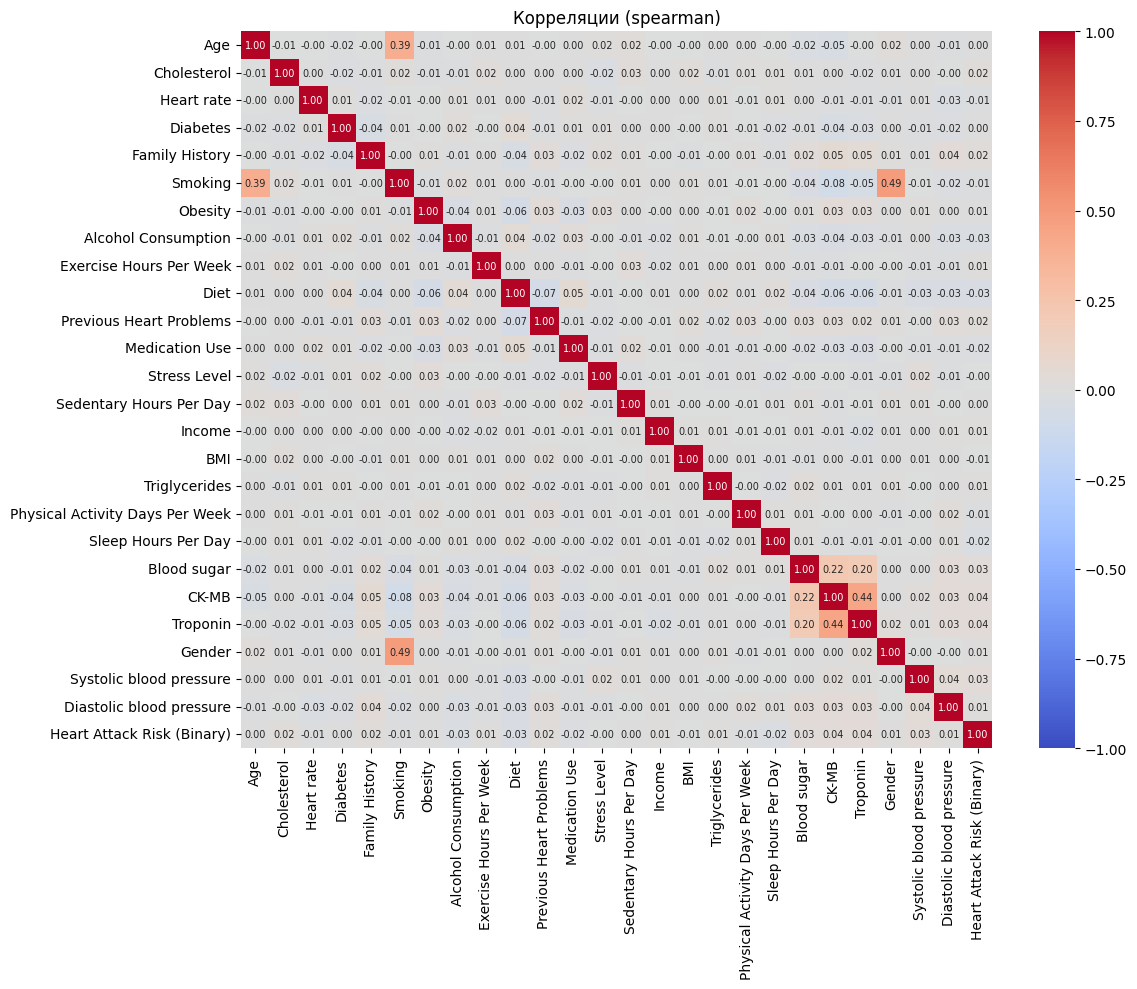

### TRAIN · пропуски (шт)

Smoking                            243
Family History                     243
Diabetes                           243
Alcohol Consumption                243
Previous Heart Problems            243
Obesity                            243
Medication Use                     243
Stress Level                       243
Physical Activity Days Per Week    243
dtype: int64

### TRAIN · пики (автопоиск)

""


### TRAIN · выбросы (IQR)

,Признак,N,% выбросов,Нижняя граница,Верхняя граница,Мин. выброс,Макс. выброс
1,Blood sugar,8685,24.57,0.227018,0.227018,0.0,1.0
2,CK-MB,8685,24.57,0.048229,0.048229,0.0,1.0
3,Troponin,8685,24.57,0.036512,0.036512,0.0,1.0
0,Heart rate,8685,0.02,-0.011916,0.112741,1.0,1.0


### TRAIN · таргет: распределение классов

,Класс,Количество,%
0,0,5672,65.31
1,1,3013,34.69


### TRAIN · таргет по категориям и флагам *_was_nan

,Признак,Значение,N,% класса=1
0,Alcohol Consumption,0.0,3360,36.55
1,Alcohol Consumption,1.0,5325,33.52
2,Alcohol Consumption_was_nan,0.0,8442,35.69
3,Alcohol Consumption_was_nan,1.0,243,0.00
4,Diabetes,1.0,5748,34.73
5,Diabetes,0.0,2937,34.63
6,Diabetes_was_nan,0.0,8442,35.69
7,Diabetes_was_nan,1.0,243,0.00
8,Diet,1.0,2863,36.95
9,Diet,2.0,2796,35.23


### TRAIN · таргет по квантилям непрерывных (децили)

,Признак,Квантиль,Мин,Макс,N,% класса=1
0,Age,"(-0.001, 0.124]",-0.001,0.124,902,35.70
1,Age,"(0.124, 0.213]",0.124,0.213,909,35.31
2,Age,"(0.213, 0.292]",0.213,0.292,803,34.74
3,Age,"(0.292, 0.382]",0.292,0.382,970,35.88
4,Age,"(0.382, 0.461]",0.382,0.461,873,31.16
5,Age,"(0.461, 0.528]",0.461,0.528,828,31.52
6,Age,"(0.528, 0.596]",0.528,0.596,804,33.08
7,Age,"(0.596, 0.685]",0.596,0.685,968,36.78
8,Age,"(0.685, 0.775]",0.685,0.775,830,34.22
9,Age,"(0.775, 1.0]",0.775,1.000,798,38.10


### TRAIN · графики: доля класса=1 по категориям

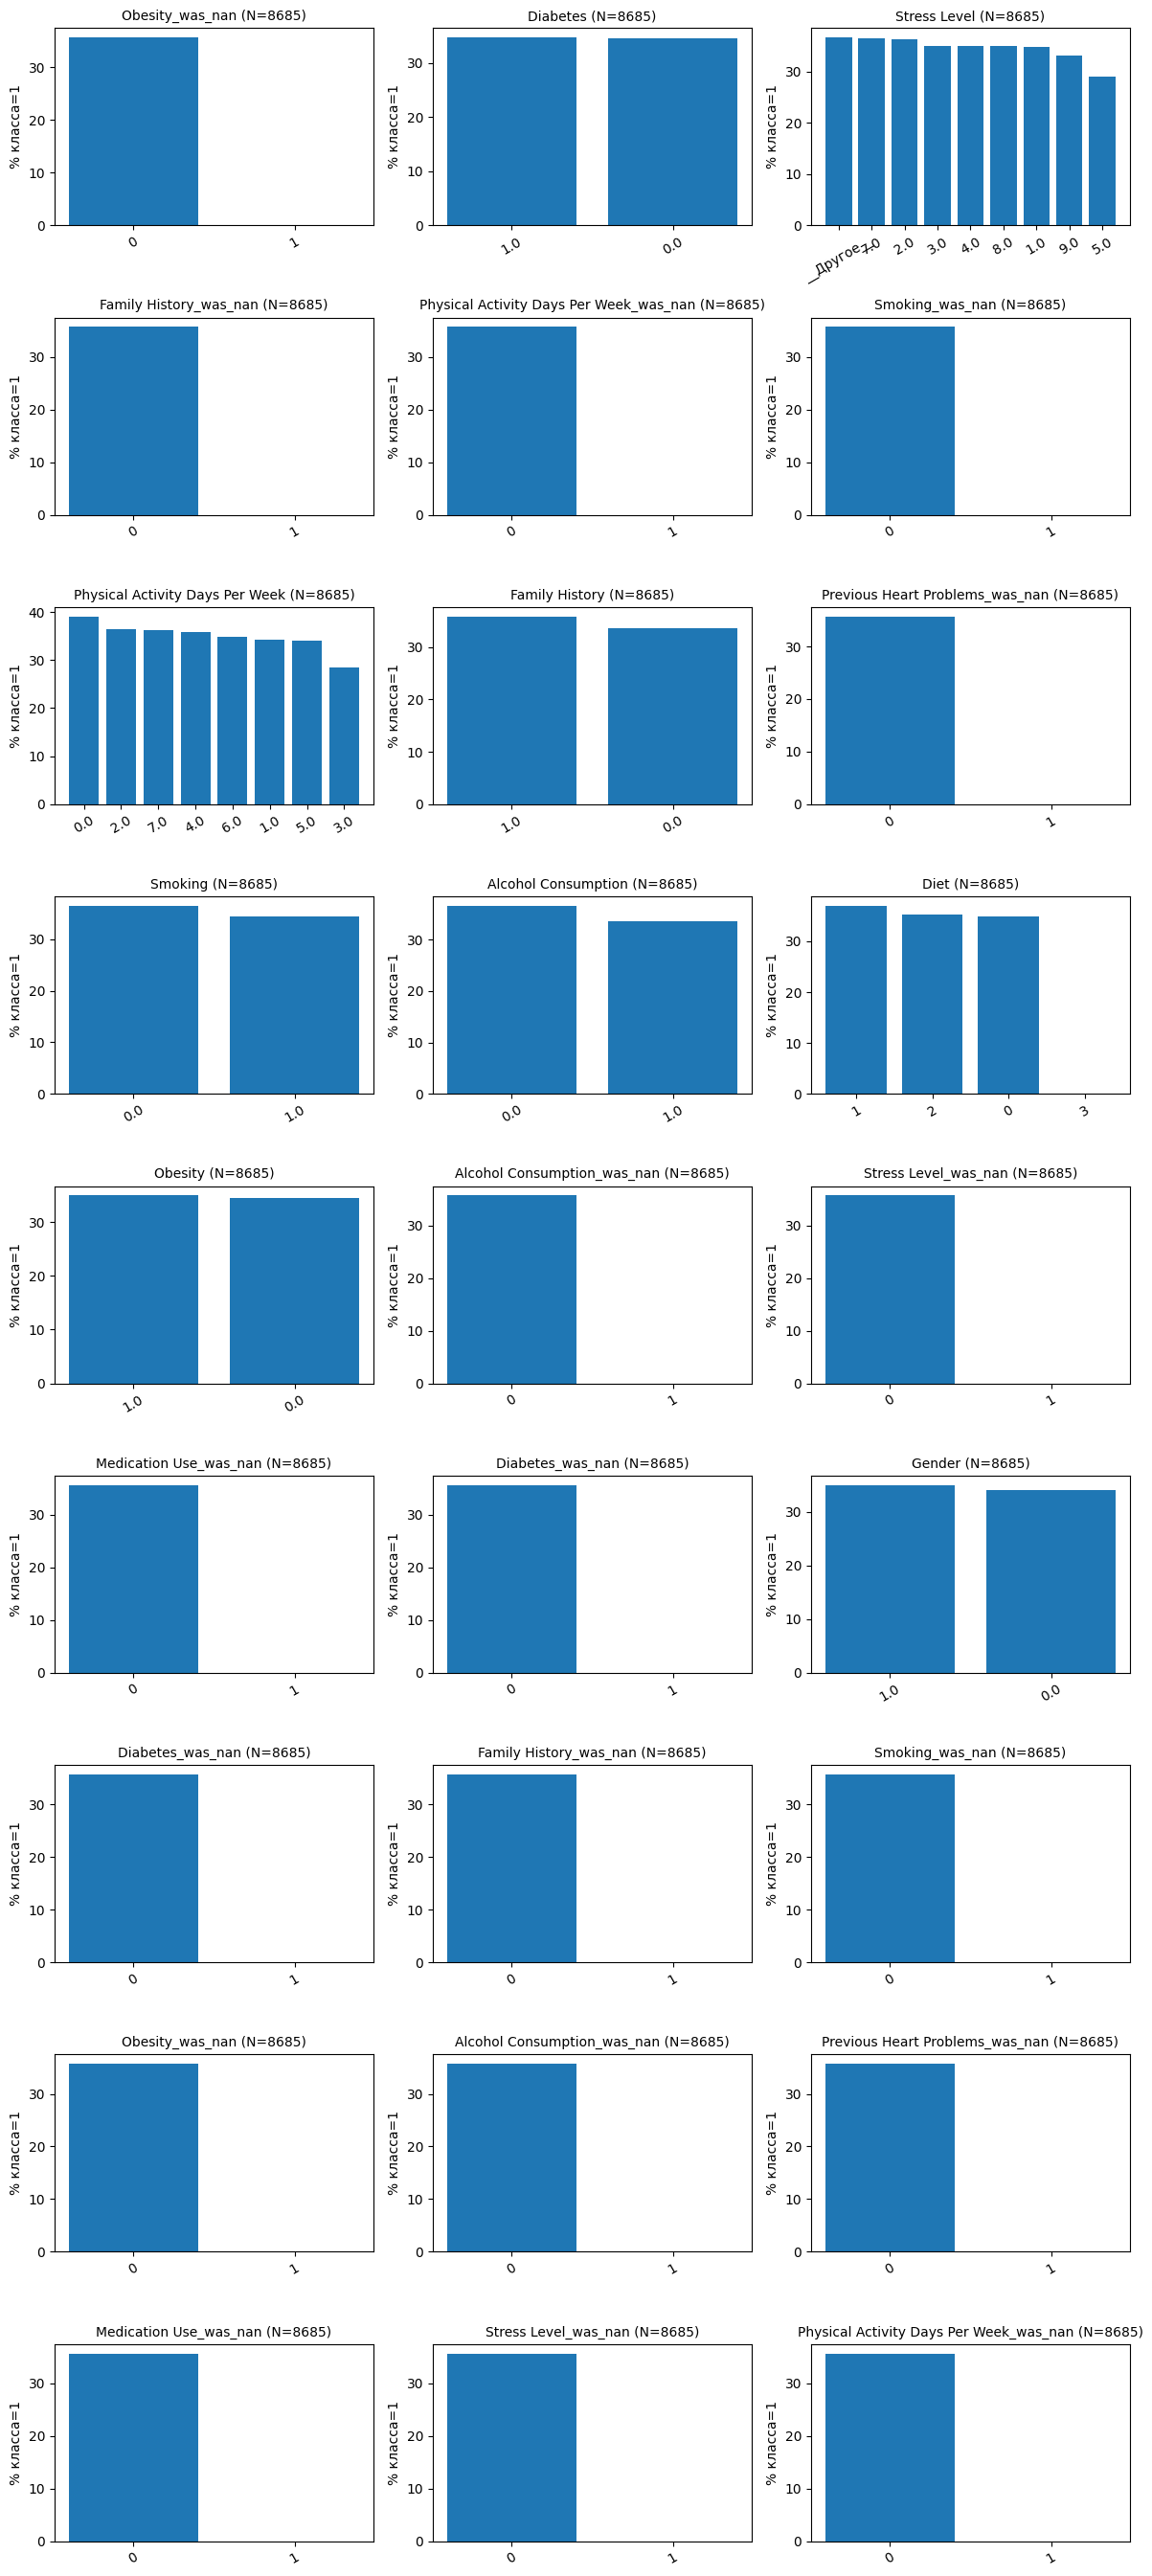

### TRAIN · графики: boxplot непрерывных vs таргет

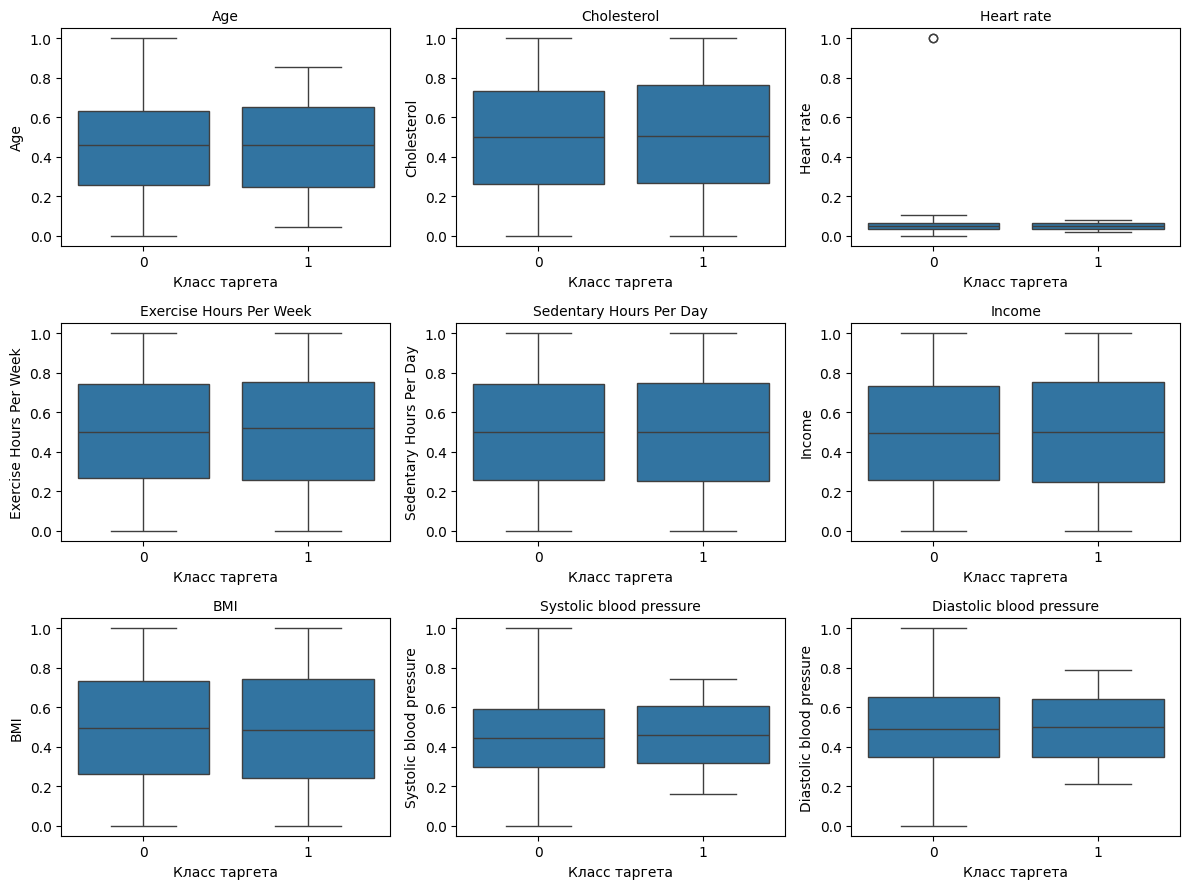

---

### TEST · состав фичей (тип / уникальные / пропуски)

,тип,уникальные,пропуски
Age,float64,73,0
Alcohol Consumption,float64,2,0
Alcohol Consumption_was_nan,int64,2,0
BMI,float64,924,0
Blood sugar,float64,124,0
CK-MB,float64,183,0
Cholesterol,float64,266,0
Diabetes,float64,2,0
Diabetes_was_nan,int64,2,0
Diastolic blood pressure,float64,54,0


### TEST · пропуски (шт)

Family History                     31
Diabetes                           31
Alcohol Consumption                31
Obesity                            31
Smoking                            31
Previous Heart Problems            31
Physical Activity Days Per Week    31
Stress Level                       31
Medication Use                     31
dtype: int64

### TEST · пики (автопоиск)

,feature,bin_center,bin_left,bin_right,count,pct_in_bin
0,Income,0.459638,0.418157,0.501118,124,12.84


### TEST · выбросы (IQR)

,Признак,N,% выбросов,Нижняя граница,Верхняя граница,Мин. выброс,Макс. выброс
1,Blood sugar,966,24.84,0.227018,0.227018,0.029644,0.750988
2,CK-MB,966,24.84,0.048229,0.048229,0.000000,1.000000
3,Troponin,966,24.84,0.036512,0.036512,0.000194,0.970871
0,Heart rate,966,0.10,-0.007333,0.109991,1.000000,1.000000


In [206]:
# Запуск EDA


# 1) Запуск
eda = EDAHelper(
    target="Heart Attack Risk (Binary)", id_col="id",
    technical_cols=("Unnamed: 0",),
    leakage_cols=("Troponin","CK-MB","Previous Heart Problems","Medication Use"),
    proxy_cols=("Triglycerides","Blood sugar"),
    ordinal_cols_guess=("Stress Level","Physical Activity Days Per Week","Diet"),
    gender_col="Gender",
)
res = eda.fit_report(train_df, test_df)

# 2) Хелперы
hdr = lambda t: display(Markdown(f"### {t}"))
sep = lambda: display(Markdown("---"))
def feature_summary(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "тип": df.dtypes,
        "уникальные": df.nunique(dropna=True),
        "пропуски": df.isna().sum()
    }).sort_index()

tr = res["train_clean"]
ts = res["test_clean"]

# 3) Cаммари (общее)
display(Markdown("## Итоговый отчёт EDA "))
display(Markdown(res["reports"]["summary_md"]))

# 4) Проверка ID между выборками
hdr("Проверка ID (train ↔ test)")
id_chk = res["reports"]["id_check"]
display(Markdown(
    f"- Уникальные ID в train: **{id_chk.get('train_ids','—')}**, дубликаты: **{id_chk.get('dup_train','—')}**  \n"
    f"- Уникальные ID в test: **{id_chk.get('test_ids','—')}**, дубликаты: **{id_chk.get('dup_test','—')}**  \n"
    f"- Пересечение train∩test: **{id_chk.get('intersection','—')}**"
    + (f" (примеры: {', '.join(map(str, id_chk.get('intersection_sample', [])))})"
       if id_chk.get('intersection', 0) > 0 else "")
))

# ------------------------------ TRAIN ------------------------------
sep(); hdr("TRAIN · состав фичей (тип / уникальные / пропуски)")
display(feature_summary(tr))

hdr("TRAIN · матрица корреляций (Spearman)")
eda.corr_heatmap(tr, method="spearman", annot=True, cbar=True, show=True)

hdr("TRAIN · пропуски (шт)")
display(res["reports"]["missing_train"][res["reports"]["missing_train"] > 0])

hdr("TRAIN · пики (автопоиск)")
display(res["reports"]["peaks"].head(30) if res["reports"]["peaks"] is not None else pd.DataFrame())

hdr("TRAIN · выбросы (IQR)")
display(res["reports"]["outliers"].head(30) if res["reports"]["outliers"] is not None else pd.DataFrame())

hdr("TRAIN · таргет: распределение классов")
display(res["reports"]["target_distribution"])

tbc = res["reports"].get("target_by_cats")
if tbc is not None and not tbc.empty:
    hdr("TRAIN · таргет по категориям и флагам *_was_nan")
    display(tbc.head(40))

tbq = res["reports"].get("target_by_quantiles")
if tbq is not None and not tbq.empty:
    hdr("TRAIN · таргет по квантилям непрерывных (децили)")
    display(tbq.head(40))

hdr("TRAIN · графики: доля класса=1 по категориям")
eda.plot_target_rate_by_cats(tr)

hdr("TRAIN · графики: boxplot непрерывных vs таргет")
eda.plot_box_by_target(tr)

# ------------------------------ TEST ------------------------------
sep(); hdr("TEST · состав фичей (тип / уникальные / пропуски)")
display(feature_summary(ts))

hdr("TEST · пропуски (шт)")
display(res["reports"]["missing_test"][res["reports"]["missing_test"] > 0])

hdr("TEST · пики (автопоиск)")
peaks_test = eda.detect_peaks_auto(ts, bins="fd", min_share=0.02, prominence=1.5, top_k=3)
display(peaks_test.head(30))

hdr("TEST · выбросы (IQR)")
outs_test = eda.detect_outliers(ts, method="iqr", iqr_factor=1.5)
display(outs_test.head(30))
